# Testing the BC Algorithm
## (naively, with on-expert-trajectory data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from bc import BC_Agent

All the policy setup is here. Needs to match the parameters used to train the model originally. 

In [2]:
data_rel_paths = [
    # "../../sim_mujoco/data/dataset_backwards.csv", "../../sim_mujoco/data/dataset_forward_sideways.csv", "../../sim_mujoco/data/dataset_misc.csv"
    # "../../sim_mujoco/data/in_place_long.csv"
    # "../../sim_mujoco/data/in_place.csv"
    "../data_processing/updated_data/no_controller_input_v4.csv"
]
policy_name = "bc_v4_fixed_data_all_normalized_no_duplicate_inputs"
# Fraction of data to train on. If you are going to test the policy on the biped in sim, use 1. (no reason to leave any data out)
train_frac = 0.9


# state_columns = [
#     "L_YAW_pos", "L_HAA_pos", "L_HFE_pos", "L_KFE_pos", "L_ANKLE_pos",
#     "R_YAW_pos", "R_HAA_pos", "R_HFE_pos", "R_KFE_pos", "R_ANKLE_pos",
#     "L_YAW_vel", "L_HAA_vel", "L_HFE_vel", "L_KFE_vel", "L_ANKLE_vel",
#     "R_YAW_vel", "R_HAA_vel", "R_HFE_vel", "R_KFE_vel", "R_ANKLE_vel", 
#     "vel_x_BF", "vel_y_BF", "vel_z_BF", "normal_vec_x_BF", "normal_vec_y_BF", "normal_vec_z_BF", 
#     "omega_x", "omega_y", "omega_z", "vx_des_BF", "vy_des_BF", 
#     "right_foot_t_since_contact", "right_foot_t_since_no_contact", 
#     "right_foot_pos_x_BF", "right_foot_pos_y_BF", "right_foot_pos_z_BF",
#     "left_foot_t_since_contact", "left_foot_t_since_no_contact",
#     "left_foot_pos_x_BF", "left_foot_pos_y_BF", "left_foot_pos_z_BF"
# ]

state_columns = [
    "L_YAW_pos", "L_HAA_pos", "L_HFE_pos", "L_KFE_pos", "L_ANKLE_pos",
    "R_YAW_pos", "R_HAA_pos", "R_HFE_pos", "R_KFE_pos", "R_ANKLE_pos",
    "L_YAW_vel", "L_HAA_vel", "L_HFE_vel", "L_KFE_vel", "L_ANKLE_vel",
    "R_YAW_vel", "R_HAA_vel", "R_HFE_vel", "R_KFE_vel", "R_ANKLE_vel", 
    "vel_x_BF", "vel_y_BF", "vel_z_BF", "normal_vec_x_BF", "normal_vec_y_BF", "normal_vec_z_BF", 
    "omega_x", "omega_y", "omega_z", "vx_des_BF", "vy_des_BF", 
    "right_foot_t_since_contact", "right_foot_t_since_no_contact", 
    "right_foot_pos_x_BF", "right_foot_pos_y_BF", "right_foot_pos_z_BF",
    "left_foot_t_since_contact", "left_foot_t_since_no_contact",
    "left_foot_pos_x_BF", "left_foot_pos_y_BF", "left_foot_pos_z_BF"
]
action_columns = [
    "L_YAW_tau_ff", "L_HAA_tau_ff", "L_HFE_tau_ff", "L_KFE_tau_ff", "L_ANKLE_tau_ff",
    "R_YAW_tau_ff", "R_HAA_tau_ff", "R_HFE_tau_ff", "R_KFE_tau_ff", "R_ANKLE_tau_ff",
    "L_YAW_q_des", "L_HAA_q_des", "L_HFE_q_des", "L_KFE_q_des", "L_ANKLE_q_des",
    "R_YAW_q_des", "R_HAA_q_des", "R_HFE_q_des", "R_KFE_q_des", "R_ANKLE_q_des",
    "L_YAW_q_vel_des", "L_HAA_q_vel_des", "L_HFE_q_vel_des", "L_KFE_q_vel_des", "L_ANKLE_q_vel_des",
    "R_YAW_q_vel_des", "R_HAA_q_vel_des", "R_HFE_q_vel_des", "R_KFE_q_vel_des", "R_ANKLE_q_vel_des"
]
use_spectral_norm = True
num_input_states = 1 # Number of states to include in input
layer1 = 256 * 7
layer2 = 512 * 7
layer3 = 512 * 7
layer4 = 256 * 7
policy_arch = [
    {'Layer': 'Linear', 'Input': len(state_columns) * num_input_states, 'Output': layer1, 'SpectralNorm': use_spectral_norm},
    {'Layer': 'ReLU'},
    {'Layer': 'Linear', 'Input': layer1, 'Output': layer2, 'SpectralNorm': use_spectral_norm},
    {'Layer': 'ReLU'},
    {'Layer': 'Linear', 'Input': layer2, 'Output': layer3, 'SpectralNorm': use_spectral_norm},
    {'Layer': 'ReLU'},
    {'Layer': 'Linear', 'Input': layer3, 'Output': layer4, 'SpectralNorm': use_spectral_norm},
    {'Layer': 'ReLU'},
    {'Layer': 'Linear', 'Input': layer4, 'Output': len(action_columns), 'SpectralNorm': use_spectral_norm}
]
print(len(state_columns))


41


Format the data so that the policy can predict on the states (on the expert trajectory). No interface with sim, just comparing policy actions with expert actions on expert trajectory. 

In [3]:
dataset = pd.DataFrame()
for dp in data_rel_paths:
    ds = pd.read_csv(dp)
    dataset = pd.concat((dataset, ds))
num_steps = dataset.shape[0]
states = dataset[state_columns].to_numpy(dtype=np.float64)
actions = dataset[action_columns].to_numpy(dtype=np.float64)

print(states.shape)
print(states[0])

# Stack states if more than one included in input
states = np.hstack([states[ii: states.shape[0] - (num_input_states - ii - 1), :] for ii in range(num_input_states)])
print(states.shape)
print(states[0])
actions = actions[num_input_states - 1:, :]

# grab the data excluded from training for fair test
test_states = states[int(num_steps * train_frac):, :]
test_actions = actions[int(num_steps * train_frac):, :]

print(dataset.shape)

(41148, 41)
[0.81658695 0.         0.54284607 0.94444906 0.10497302 0.08010172
 0.70530764 0.03747251 0.44692243 0.62459072 0.89437715 0.53214731
 0.756883   0.18987105 0.74604075 0.92792986 0.80340248 0.87114416
 0.13287583 0.22910114 0.99897913 0.46884943 0.99765981 0.59567472
 0.08673845 0.28619889 0.53719196 0.99946913 0.88186364 0.76776777
 0.6845889  0.99349349 0.         0.97945185 0.49249314 0.00325261
 0.51551552 0.         0.98406489 0.49450461 0.00357679]
(41148, 41)
[0.81658695 0.         0.54284607 0.94444906 0.10497302 0.08010172
 0.70530764 0.03747251 0.44692243 0.62459072 0.89437715 0.53214731
 0.756883   0.18987105 0.74604075 0.92792986 0.80340248 0.87114416
 0.13287583 0.22910114 0.99897913 0.46884943 0.99765981 0.59567472
 0.08673845 0.28619889 0.53719196 0.99946913 0.88186364 0.76776777
 0.6845889  0.99349349 0.         0.97945185 0.49249314 0.00325261
 0.51551552 0.         0.98406489 0.49450461 0.00357679]
(41148, 71)


Predict on the availabe data (which was excluded from training)

In [4]:
# Run vanilla behavior cloning

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print("device: ", device)
print(states.shape[1])
print(actions.shape[1])
# Remember means/stds will be loaded, but need to pass tensors of the right shape
bc_agent = BC_Agent(policy_arch, torch.zeros(states.shape[1]), torch.zeros(states.shape[1]), torch.zeros(actions.shape[1]), torch.zeros(actions.shape[1]))
bc_agent.load_policy(f"policies/{policy_name}.pt")
bc_agent.to(device)

policy_actions = bc_agent.get_action(torch.tensor(test_states, dtype=torch.float32).to(device))

print(policy_actions.shape)


device:  cuda
41
30
torch.Size([4115, 30])


And now do some plotting to examine results

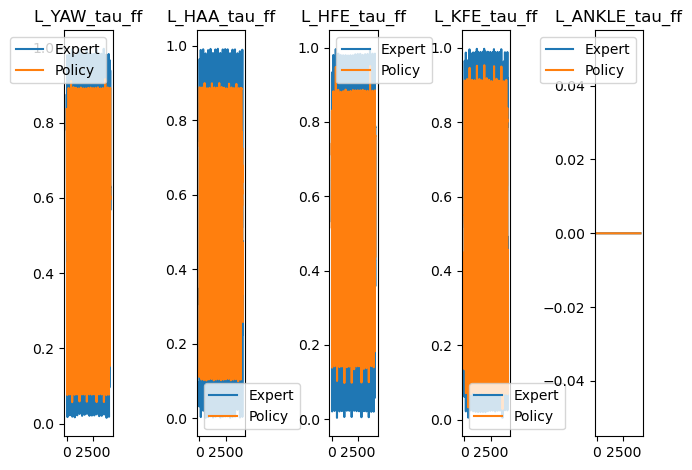

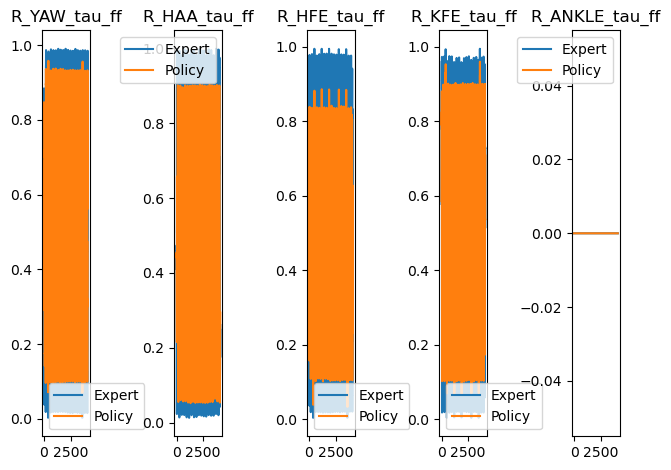

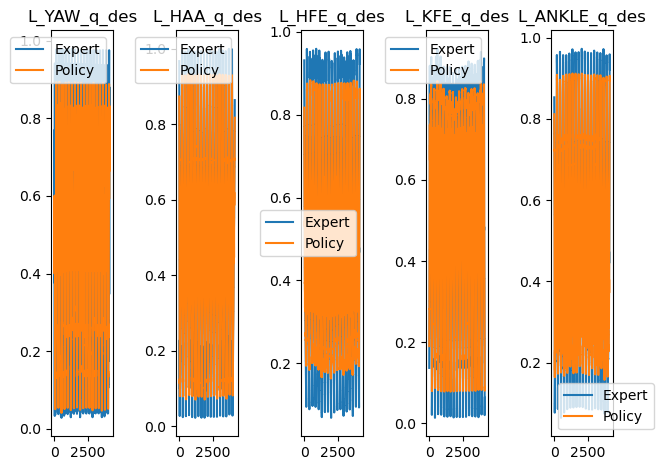

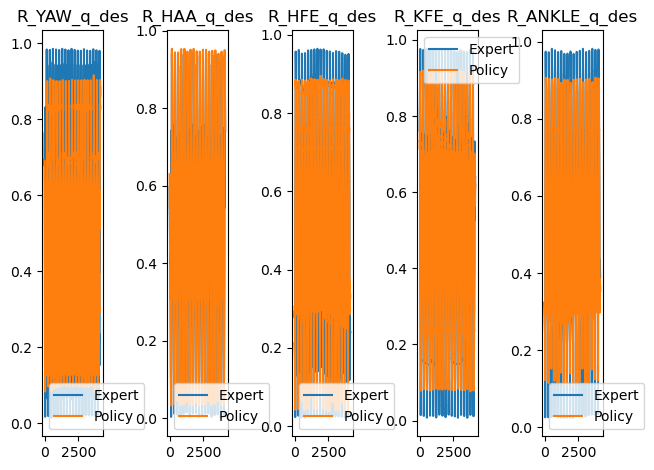

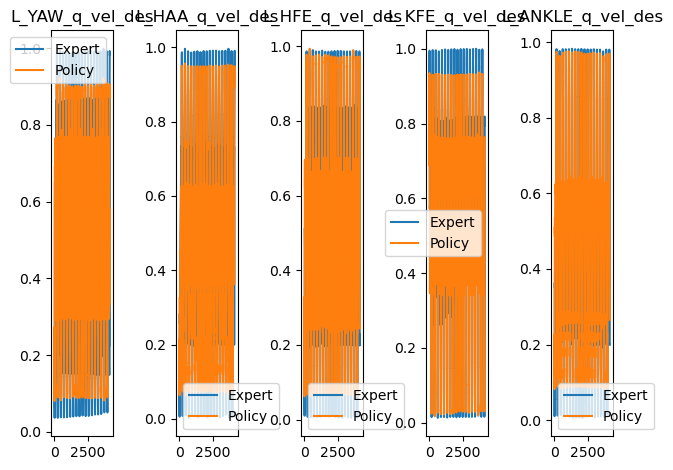

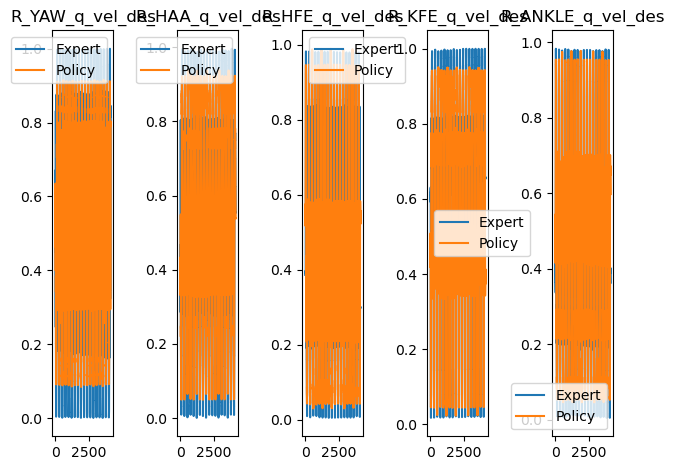

In [5]:
plt.figure()
# create multiple subplots to compare the actions
factor = 6
for j in range(factor):
    for ii in range(len(action_columns) // factor):
        plt.subplot(1, 5, ii + 1)
        index = (j * (len(action_columns) // factor)) + ii
        plt.plot(test_actions[:, index], label="Expert")
        plt.plot(policy_actions[:, index].cpu().detach().numpy(), label="Policy")
        plt.title(action_columns[index])
        plt.legend()
    plt.tight_layout()
    plt.show()

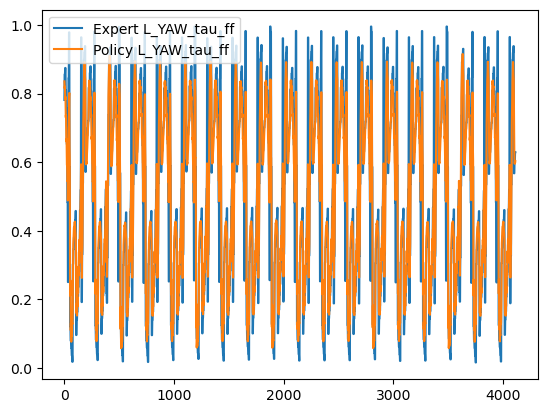

In [6]:
plt.figure()
plt.plot(test_actions[:, 0])
plt.plot(policy_actions[:, 0].to("cpu").detach().numpy())
plt.legend(['Expert L_YAW_tau_ff', 'Policy L_YAW_tau_ff'])
plt.show()

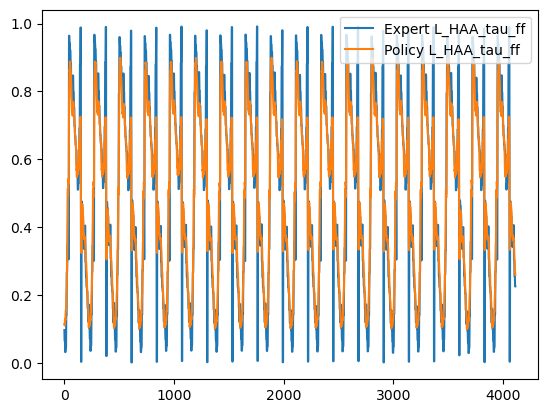

In [7]:
plt.figure()
plt.plot(test_actions[:, 1])
plt.plot(policy_actions[:, 1].to("cpu").detach().numpy())
plt.legend(['Expert L_HAA_tau_ff', 'Policy L_HAA_tau_ff'])
plt.show()

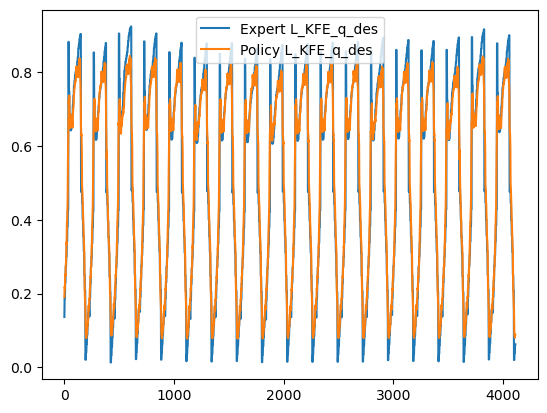

In [8]:
plt.figure()
plt.plot(test_actions[:, 13])
plt.plot(policy_actions[:, 13].to("cpu").detach().numpy())
plt.legend(['Expert L_KFE_q_des', 'Policy L_KFE_q_des'])
plt.show()

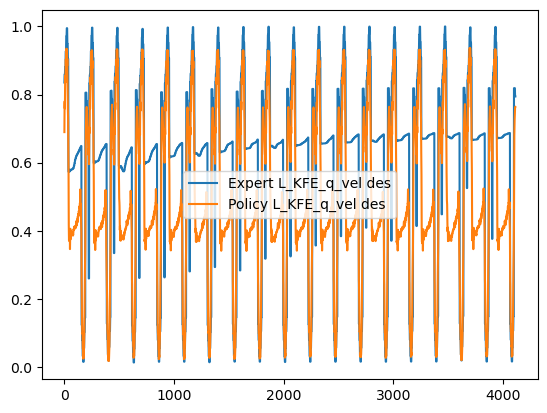

In [9]:
plt.figure()
plt.plot(test_actions[:, 23])
plt.plot(policy_actions[:, 23].to("cpu").detach().numpy())
plt.legend(['Expert L_KFE_q_vel des', 'Policy L_KFE_q_vel des'])
plt.show()

In [10]:
# Now unscale the data and compare with original.
from pickle import load
with open("../data_processing/updated_data/action_scaler_v4.pkl", "rb") as f:
    scaler_a = load(f)

policy_actions_unscaled = scaler_a.inverse_transform(policy_actions.cpu().detach().numpy())

In [11]:
# OG data:
og_data = "../../sim_mujoco/data/no_controller_input.csv"
og_data = pd.read_csv(og_data)
og_num_steps = og_data.shape[0]
og_actions = og_data[action_columns].to_numpy(dtype=np.float64)
og_test_actions = og_actions[int(og_num_steps * train_frac):, :]



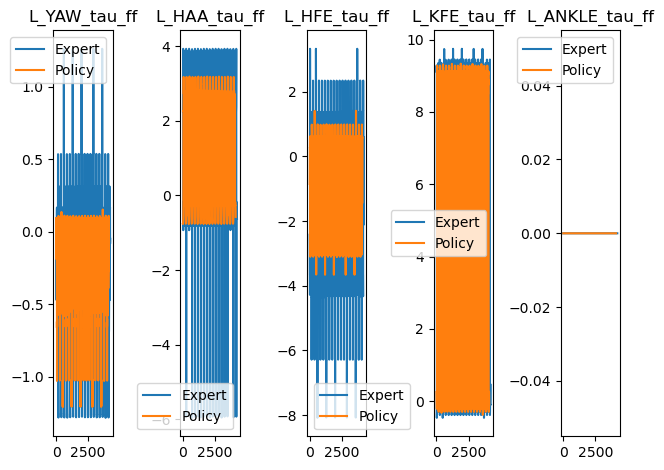

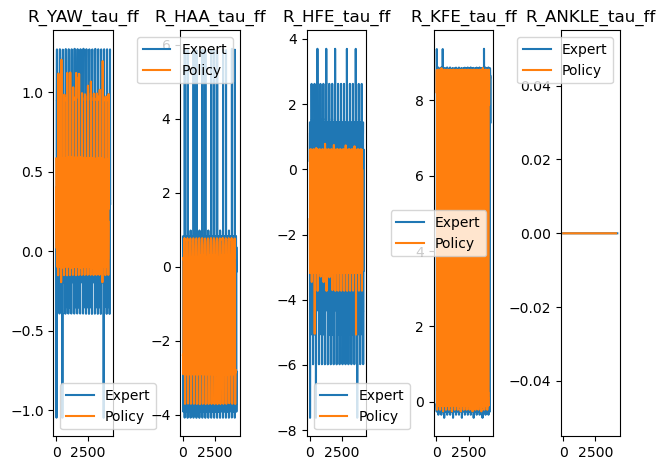

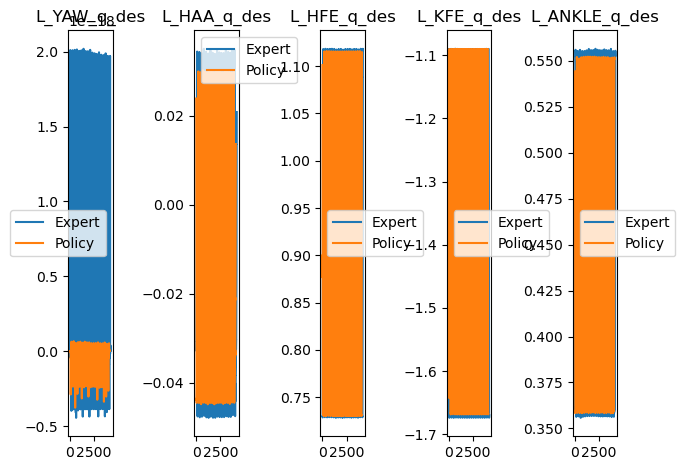

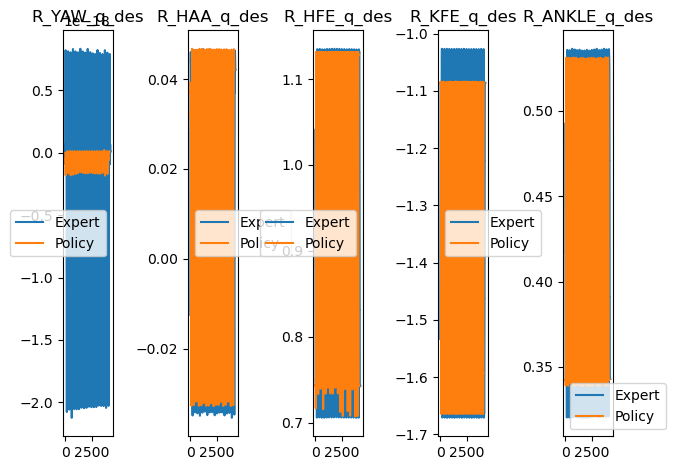

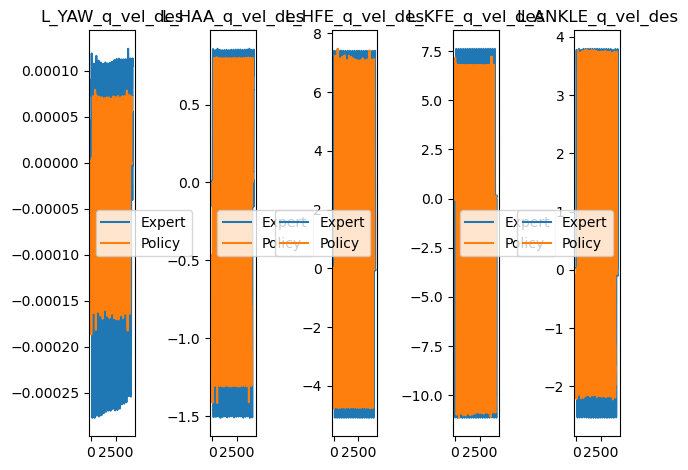

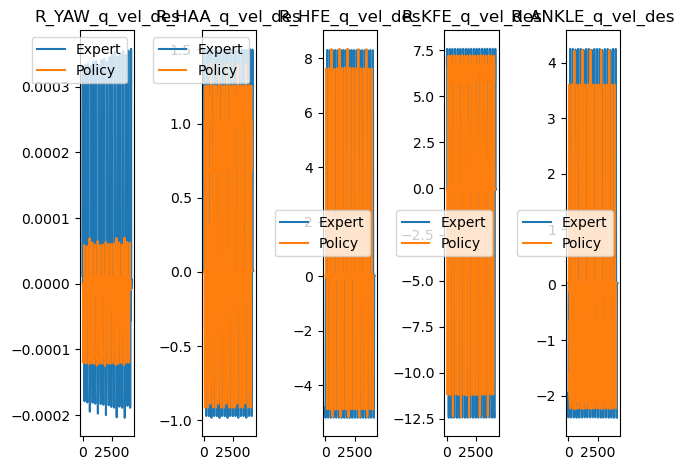

In [12]:
plt.figure()
# create multiple subplots to compare the actions
factor = 6
for j in range(factor):
    for ii in range(len(action_columns) // factor):
        plt.subplot(1, 5, ii + 1)
        index = (j * (len(action_columns) // factor)) + ii
        plt.plot(og_test_actions[:, index], label="Expert")
        plt.plot(policy_actions_unscaled[:, index], label="Policy")
        plt.title(action_columns[index])
        plt.legend()
    plt.tight_layout()
    plt.show()